In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
%shell
dataset_path="/content/MyDrive/MyDrive/CS313/Project"
%cd $dataset_path

/content/MyDrive/MyDrive/CS313/Project


In [3]:
import os
import pandas as pd
import numpy as np
from duckdb import query as dbquery
import seaborn as sbn
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [4]:
def transposeDataFrame(df, col_name, start_idx):
  df2 = pd.DataFrame(df.values[:, start_idx:].astype(np.float64).T, columns=df[col_name].to_list())
  df2.insert(loc=0, column='timestep', value=df.columns[start_idx:])
  return df2

In [ ]:
# dataset = list(filter(lambda x: x[-4:] == ".csv", os.listdir('.')))

In [5]:
dataset = ['10_Renewable_Energy.csv',
 '23_Annual_Surface_Temperature_Change.csv',
 '26_Land_Cover_Accounts.csv',
 '14_Climate-related_Disasters_Frequency.csv',
 '1_Quarterly_Greenhouse_Gas_GHG_Air_Emissions_Accounts.csv',
 '24_Atmospheric_CO2_Concentrations.csv',
 '25_Change_in_Mean_Sea_Levels.csv',
 '13_Forest_and_Carbon.csv']

In [6]:
irrelevant_cols = ['ISO2', "ISO3", "Source", "CTS Name", "CTS Code", 'CTS Full Descriptor']

In [7]:
data = []
for f in dataset:
  df = pd.read_csv(f).drop(columns=irrelevant_cols, errors='ignore')
  data.append(df)

In [ ]:
for i in data:
  print(len(i["Country"].unique()))

248
225
244
215
25
1
1
235


In [ ]:
temp = []
for i in range(len(data)):
  if i == 0 or i ==2 or i ==4 or i == 7:
    temp.append(data[i]["Country"].unique())
k = list(set.intersection(*map(set, temp)))
len(k)

7

In [ ]:
def check():
  for i in range(0,8):
    if 'Africa' not in data[i]["Country"].unique():
      return i
  return True
check()

1

In [8]:
countries = []
for d in data:
  countries.extend(d['Country'])

In [ ]:
countries

In [9]:
truncated_data = []
for d in data:
  truncated_data.append(dbquery("Select * from d where country = 'World';").to_df().drop(columns=['Country']))

## Data metadata
### Dataset:
1. Renewable Energy
2. Surface temperature
3. Land cover
4. Disasters
5. Greenhouse gases
6. CO2 Concentration
7. Mean sea level
8. Forest and carbon

### To-do:
1. Preprocessing all dataframes, query global datapoints (country = World)
2. Align all preprocessed dataframes to match with timesteps, choosing one timestep is one year
3. Choosing appropriated models for non-target features to extrapolate its data.
4. Train forecasting model.

In [10]:
truncated_data[2]['Indicator'] = truncated_data[2]['Indicator'] + "/" + truncated_data[2]['Climate Influence']
truncated_data[0]['Indicator'] = truncated_data[0]['Indicator'] + "/" + truncated_data[0]['Technology']

In [11]:
preprocessed_dataframes = [
  transposeDataFrame(truncated_data[0].groupby(["Indicator"]).sum().drop(["Technology","Energy Type","Unit"],axis = 1).reset_index(), "Indicator", 1).dropna(),
  transposeDataFrame(truncated_data[1], 'Unit', 2).rename({"Unit": "temperature"}),
  transposeDataFrame(truncated_data[2], "Indicator", 3)
]

In [ ]:
# preprocessed_dataframes = [
#   transposeDataFrame(truncated_data[0].query('Indicator == "Electricity Generation"'), "Technology", 4).dropna(),
#   transposeDataFrame(truncated_data[1], 'Unit', 2).rename({"Unit": "temperature"}),
#   transposeDataFrame(truncated_data[2], "Indicator", 3)
# ]

In [12]:
disasters = data[3].drop(columns=['Unit', 'Country'])
disasters = disasters.groupby(['Indicator'], as_index=False).agg('sum')
disasters['Indicator'] = disasters['Indicator'].map(lambda x: x.split(': ')[-1])
preprocessed_dataframes.append(transposeDataFrame(disasters, "Indicator", 1).drop(columns=['TOTAL']))

In [13]:
truncated_data[4]['Gas Type'] = truncated_data[4]['Gas Type'] + "/" + truncated_data[4]['Seasonal Adjustment']

In [ ]:
transposeDataFrame(truncated_data[4].groupby(["Gas Type"]).sum().drop(['Unit', 'Indicator', 'Seasonal Adjustment', 'Scale'],axis = 1).reset_index(), "Gas Type", 2)

,timestep,Carbon dioxide/Not Seasonally Adjusted,Carbon dioxide/Seasonally Adjusted,Fluorinated gases/Not Seasonally Adjusted,Fluorinated gases/Seasonally Adjusted,Greenhouse gas/Not Seasonally Adjusted,Greenhouse gas/Seasonally Adjusted,Methane/Not Seasonally Adjusted,Methane/Seasonally Adjusted,Nitrous oxide/Not Seasonally Adjusted,Nitrous oxide/Seasonally Adjusted
0,2010Q1,17289.860005,16329.745048,301.656282,284.819927,24225.348125,22419.500482,5175.141088,4641.022474,1458.690754,1163.913036
1,2010Q2,16115.797892,16848.209382,303.846714,302.095939,21964.518059,23204.004361,4478.760620,4842.533414,1066.112831,1211.165626
2,2010Q3,16319.787261,17021.923829,305.617750,312.188168,22047.549417,23370.695921,4384.135572,4811.955860,1038.008827,1224.628065
3,2010Q4,17617.148522,17142.715419,306.678789,318.695500,24264.211921,23507.426755,5089.017410,4831.542945,1251.367200,1214.472885
4,2011Q1,18135.880394,17225.853969,337.119538,317.892995,25468.026820,23700.355264,5474.575470,4924.022940,1520.451418,1232.585364
5,2011Q2,16631.704814,17364.080380,327.097152,325.141463,22535.185639,23773.961557,4502.356504,4864.511918,1074.027166,1220.227792
6,2011Q3,16867.569636,17501.294227,322.949373,329.978330,22692.741076,23932.998538,4455.471258,4884.776742,1046.750807,1216.949236
7,2011Q4,17859.522442,17403.448708,314.779951,328.933226,24526.846024,23815.484200,5103.513226,4862.604859,1249.030409,1220.497407
8,2012Q1,18519.851895,17784.583688,367.521620,346.612818,25878.108841,24316.617617,5526.152084,4992.186588,1464.583243,1193.234521
9,2012Q2,16815.193879,17494.165857,351.825913,349.359111,22756.345082,23920.223725,4522.824124,4877.316682,1066.501167,1199.382081


In [14]:
# d = truncated_data[4].query("`Seasonal Adjustment` == 'Seasonally Adjusted'").drop(columns=['Unit', 'Indicator', 'Seasonal Adjustment', 'Scale'])
# d = d.groupby('Gas Type', as_index=False).agg('sum')
d2 = transposeDataFrame(truncated_data[4].groupby(["Gas Type"]).sum().drop(['Unit', 'Indicator', 'Seasonal Adjustment', 'Scale'],axis = 1).reset_index(), "Gas Type", 2)
d2['timestep'] = d2['timestep'].map(lambda x: x[:4])
preprocessed_dataframes.append(d2.groupby('timestep', as_index=False).agg('mean'))

In [ ]:
# d = truncated_data[4].query("`Seasonal Adjustment` == 'Seasonally Adjusted'").drop(columns=['Unit', 'Indicator', 'Seasonal Adjustment', 'Scale'])
# d = d.groupby('Gas Type', as_index=False).agg('sum')
# d2 = transposeDataFrame(d, 'Gas Type', 2)
# d2['timestep'] = d2['timestep'].map(lambda x: x[:4])
# preprocessed_dataframes.append(d2.groupby('timestep', as_index=False).agg('mean'))

In [15]:
co2 = truncated_data[5].drop(columns=['Indicator'])
preprocessed_dataframes.append(dbquery('''
select substring(Date, 1, 4) timestep, avg(Value) co2_ppm
from co2
where unit like 'Parts%'
group by timestep
order by timestep;
''').to_df())

In [16]:
def toISO8601(st):
  month = st[1:3]
  day = st[4:6]
  year = st[7:11]
  return f"{year}-{month}-{day}"

truncated_data[6]['Date'] = truncated_data[6]['Date'].map(toISO8601)
truncated_data[6]['Indicator'] = truncated_data[6]["Indicator"].map(lambda x: x.split(' ')[-1])

In [17]:
sea = truncated_data[6]
mean_sea_by_year = dbquery('''
select substring(date, 1, 4) timestep, avg(Value) sea_level
from sea
where Indicator != 'Trend' and timestep != '1992'
group by timestep
order by timestep asc;
''').to_df()
preprocessed_dataframes.append(mean_sea_by_year)

In [18]:
preprocessed_dataframes.append(transposeDataFrame(truncated_data[7].query('Unit == "1000 HA"'), "Indicator", 2))

In [19]:
joined_data = None
for sub_df in preprocessed_dataframes:
  if joined_data is None:
    joined_data = sub_df.set_index('timestep')
  else:
    joined_data = joined_data.join(sub_df.set_index('timestep'), how='outer')

In [20]:
df = joined_data
df

,Electricity Generation/Bioenergy,Electricity Generation/Fossil fuels,Electricity Generation/Geothermal energy,Electricity Generation/Hydropower (excl. Pumped Storage),Electricity Generation/Marine energy,Electricity Generation/Nuclear,Electricity Generation/Other non-renewable energy,Electricity Generation/Pumped storage,Electricity Generation/Solar energy,Electricity Generation/Wind energy,...,Greenhouse gas/Not Seasonally Adjusted,Greenhouse gas/Seasonally Adjusted,Methane/Not Seasonally Adjusted,Methane/Seasonally Adjusted,Nitrous oxide/Not Seasonally Adjusted,Nitrous oxide/Seasonally Adjusted,co2_ppm,sea_level,Forest area,Land area
timestep,,,,,,,,,,,,,,,,,,,,,
1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,315.232000,NaN,NaN,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,315.980833,NaN,NaN,NaN
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,316.910000,NaN,NaN,NaN
1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,317.644167,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,318.454167,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,572041.610,1.656223e+07,94645.217,4357351.497,983.975,2679742.086,150192.309,120370.133,842411.926,1588655.688,...,24523.723881,24523.723881,5116.883505,5116.883504,1291.998530,1291.998530,414.210833,80.437216,4058927.05,1.302624e+07
2021,614023.268,1.742686e+07,95251.031,4275354.865,970.024,2789348.256,165641.040,125304.326,1033925.733,1838662.870,...,25661.844919,25661.844920,5190.441027,5190.441027,1314.280290,1314.280290,416.413333,82.428703,NaN,NaN
2022,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,25972.791313,25972.791310,5299.940441,5299.940441,1319.103714,1319.103714,418.528333,88.991610,NaN,NaN


In [21]:
correlation_matrix = df.corr()
correlation_matrix

,Electricity Generation/Bioenergy,Electricity Generation/Fossil fuels,Electricity Generation/Geothermal energy,Electricity Generation/Hydropower (excl. Pumped Storage),Electricity Generation/Marine energy,Electricity Generation/Nuclear,Electricity Generation/Other non-renewable energy,Electricity Generation/Pumped storage,Electricity Generation/Solar energy,Electricity Generation/Wind energy,...,Greenhouse gas/Not Seasonally Adjusted,Greenhouse gas/Seasonally Adjusted,Methane/Not Seasonally Adjusted,Methane/Seasonally Adjusted,Nitrous oxide/Not Seasonally Adjusted,Nitrous oxide/Seasonally Adjusted,co2_ppm,sea_level,Forest area,Land area
Electricity Generation/Bioenergy,1.000000,0.870629,0.930106,0.900924,0.911769,0.412724,0.966277,0.756207,0.852031,0.947670,...,0.044790,0.044790,0.006751,0.006751,0.138861,0.138861,0.681295,0.622711,-0.988517,0.889423
Electricity Generation/Fossil fuels,0.870629,1.000000,0.964901,0.987327,0.864710,0.745194,0.891577,0.883471,0.562255,0.693265,...,-0.336795,-0.336795,-0.419515,-0.419515,-0.318369,-0.318369,0.278364,0.199016,-0.965899,0.933833
Electricity Generation/Geothermal energy,0.930106,0.964901,1.000000,0.989939,0.887835,0.714128,0.962725,0.925058,0.720201,0.813288,...,-0.170880,-0.170880,-0.212744,-0.212744,-0.086066,-0.086066,0.377199,0.311983,-0.986464,0.868201
Electricity Generation/Hydropower (excl. Pumped Storage),0.900924,0.987327,0.989939,1.000000,0.889452,0.746550,0.929815,0.914655,0.632423,0.747694,...,-0.275432,-0.275432,-0.339075,-0.339075,-0.213824,-0.213824,0.308844,0.235944,-0.993611,0.915492
Electricity Generation/Marine energy,0.911769,0.864710,0.887835,0.889452,1.000000,0.477521,0.888453,0.755718,0.694074,0.813255,...,-0.020377,-0.020377,-0.130964,-0.130964,-0.023439,-0.023439,0.478088,0.430745,-0.844844,0.823979
Electricity Generation/Nuclear,0.412724,0.745194,0.714128,0.746550,0.477521,1.000000,0.567017,0.867968,0.181820,0.225597,...,-0.432446,-0.432446,-0.495058,-0.495058,-0.375952,-0.375952,-0.359829,-0.419082,0.135236,-0.183695
Electricity Generation/Other non-renewable energy,0.966277,0.891577,0.962725,0.929815,0.888453,0.567017,1.000000,0.865605,0.856777,0.919613,...,0.004190,0.004190,-0.015387,-0.015387,0.096426,0.096426,0.537451,0.473202,-0.946590,0.804423
Electricity Generation/Pumped storage,0.756207,0.883471,0.925058,0.914655,0.755718,0.867968,0.865605,1.000000,0.597729,0.644558,...,-0.201932,-0.201932,-0.215916,-0.215916,-0.109926,-0.109926,0.097343,0.038629,-0.767513,0.624312
Electricity Generation/Solar energy,0.852031,0.562255,0.720201,0.632423,0.694074,0.181820,0.856777,0.597729,1.000000,0.969046,...,0.465257,0.465257,0.536902,0.536902,0.620016,0.620016,0.751749,0.739149,-0.840932,0.665759
Electricity Generation/Wind energy,0.947670,0.693265,0.813288,0.747694,0.813255,0.225597,0.919613,0.644558,0.969046,1.000000,...,0.362474,0.362474,0.394820,0.394820,0.497838,0.497838,0.793704,0.761024,-0.943051,0.799247


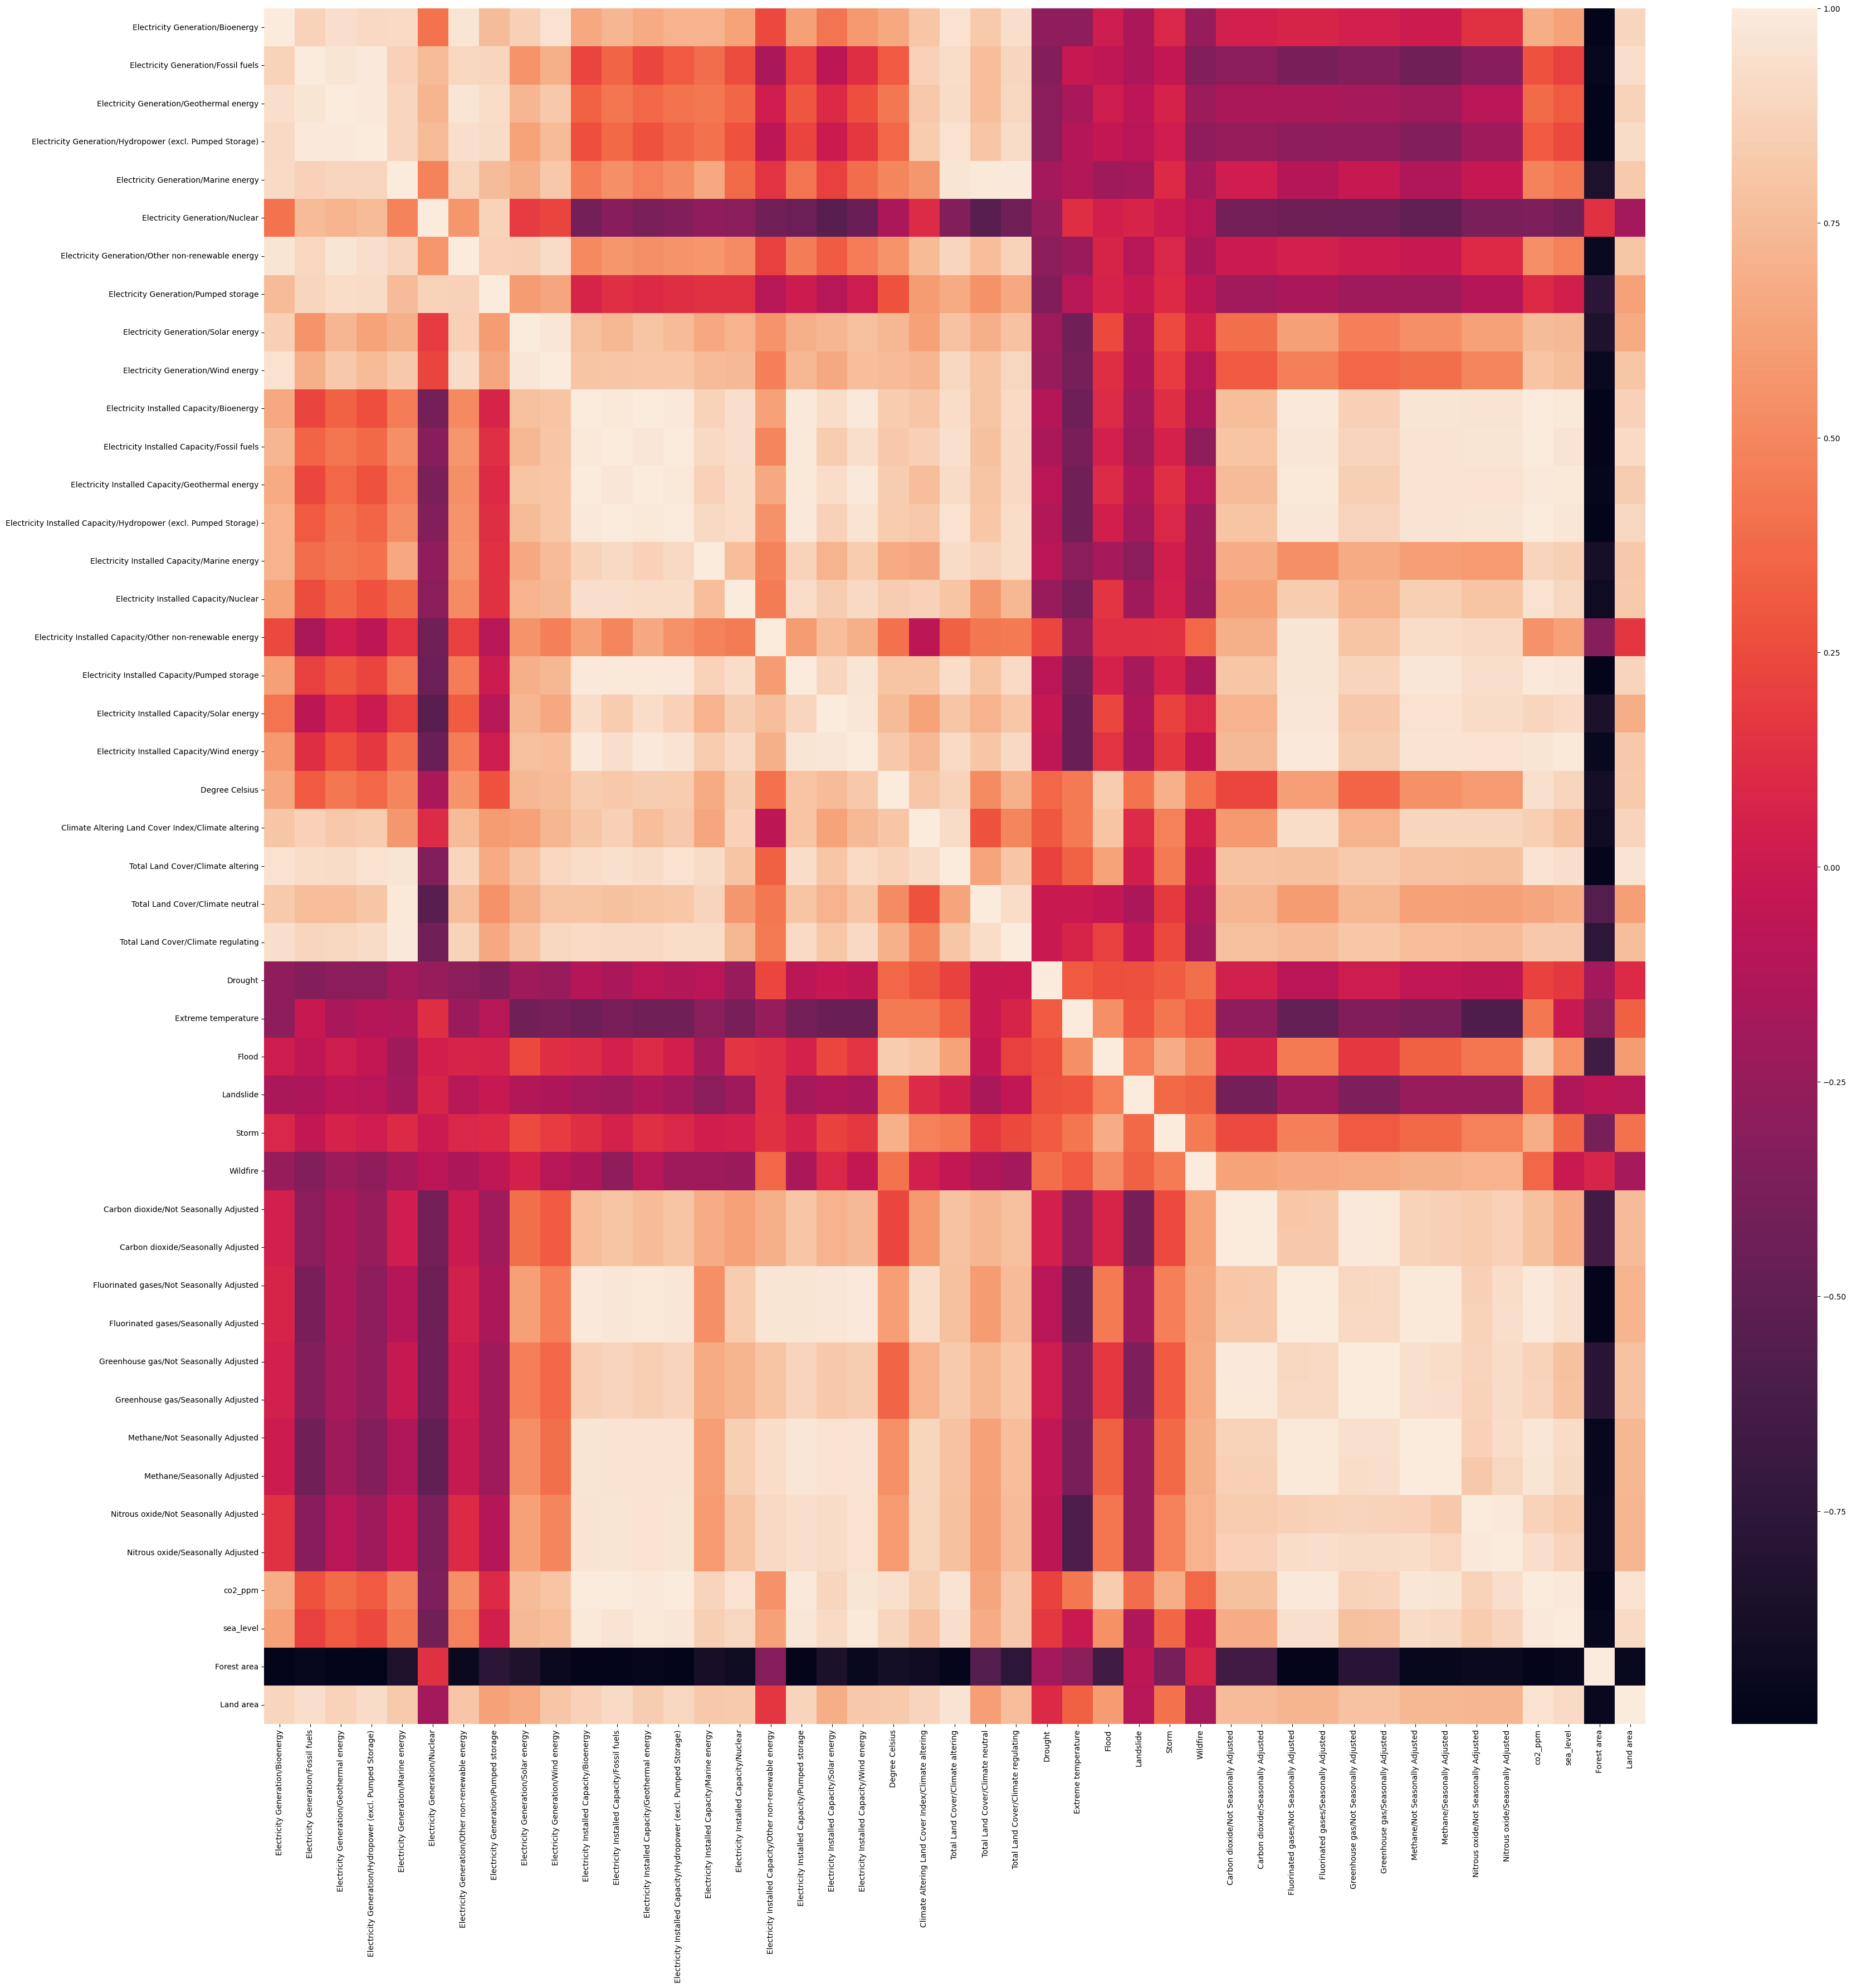

In [22]:
plt.figure(figsize=(40,40))
sbn.heatmap(correlation_matrix, annot = False)
plt.show()

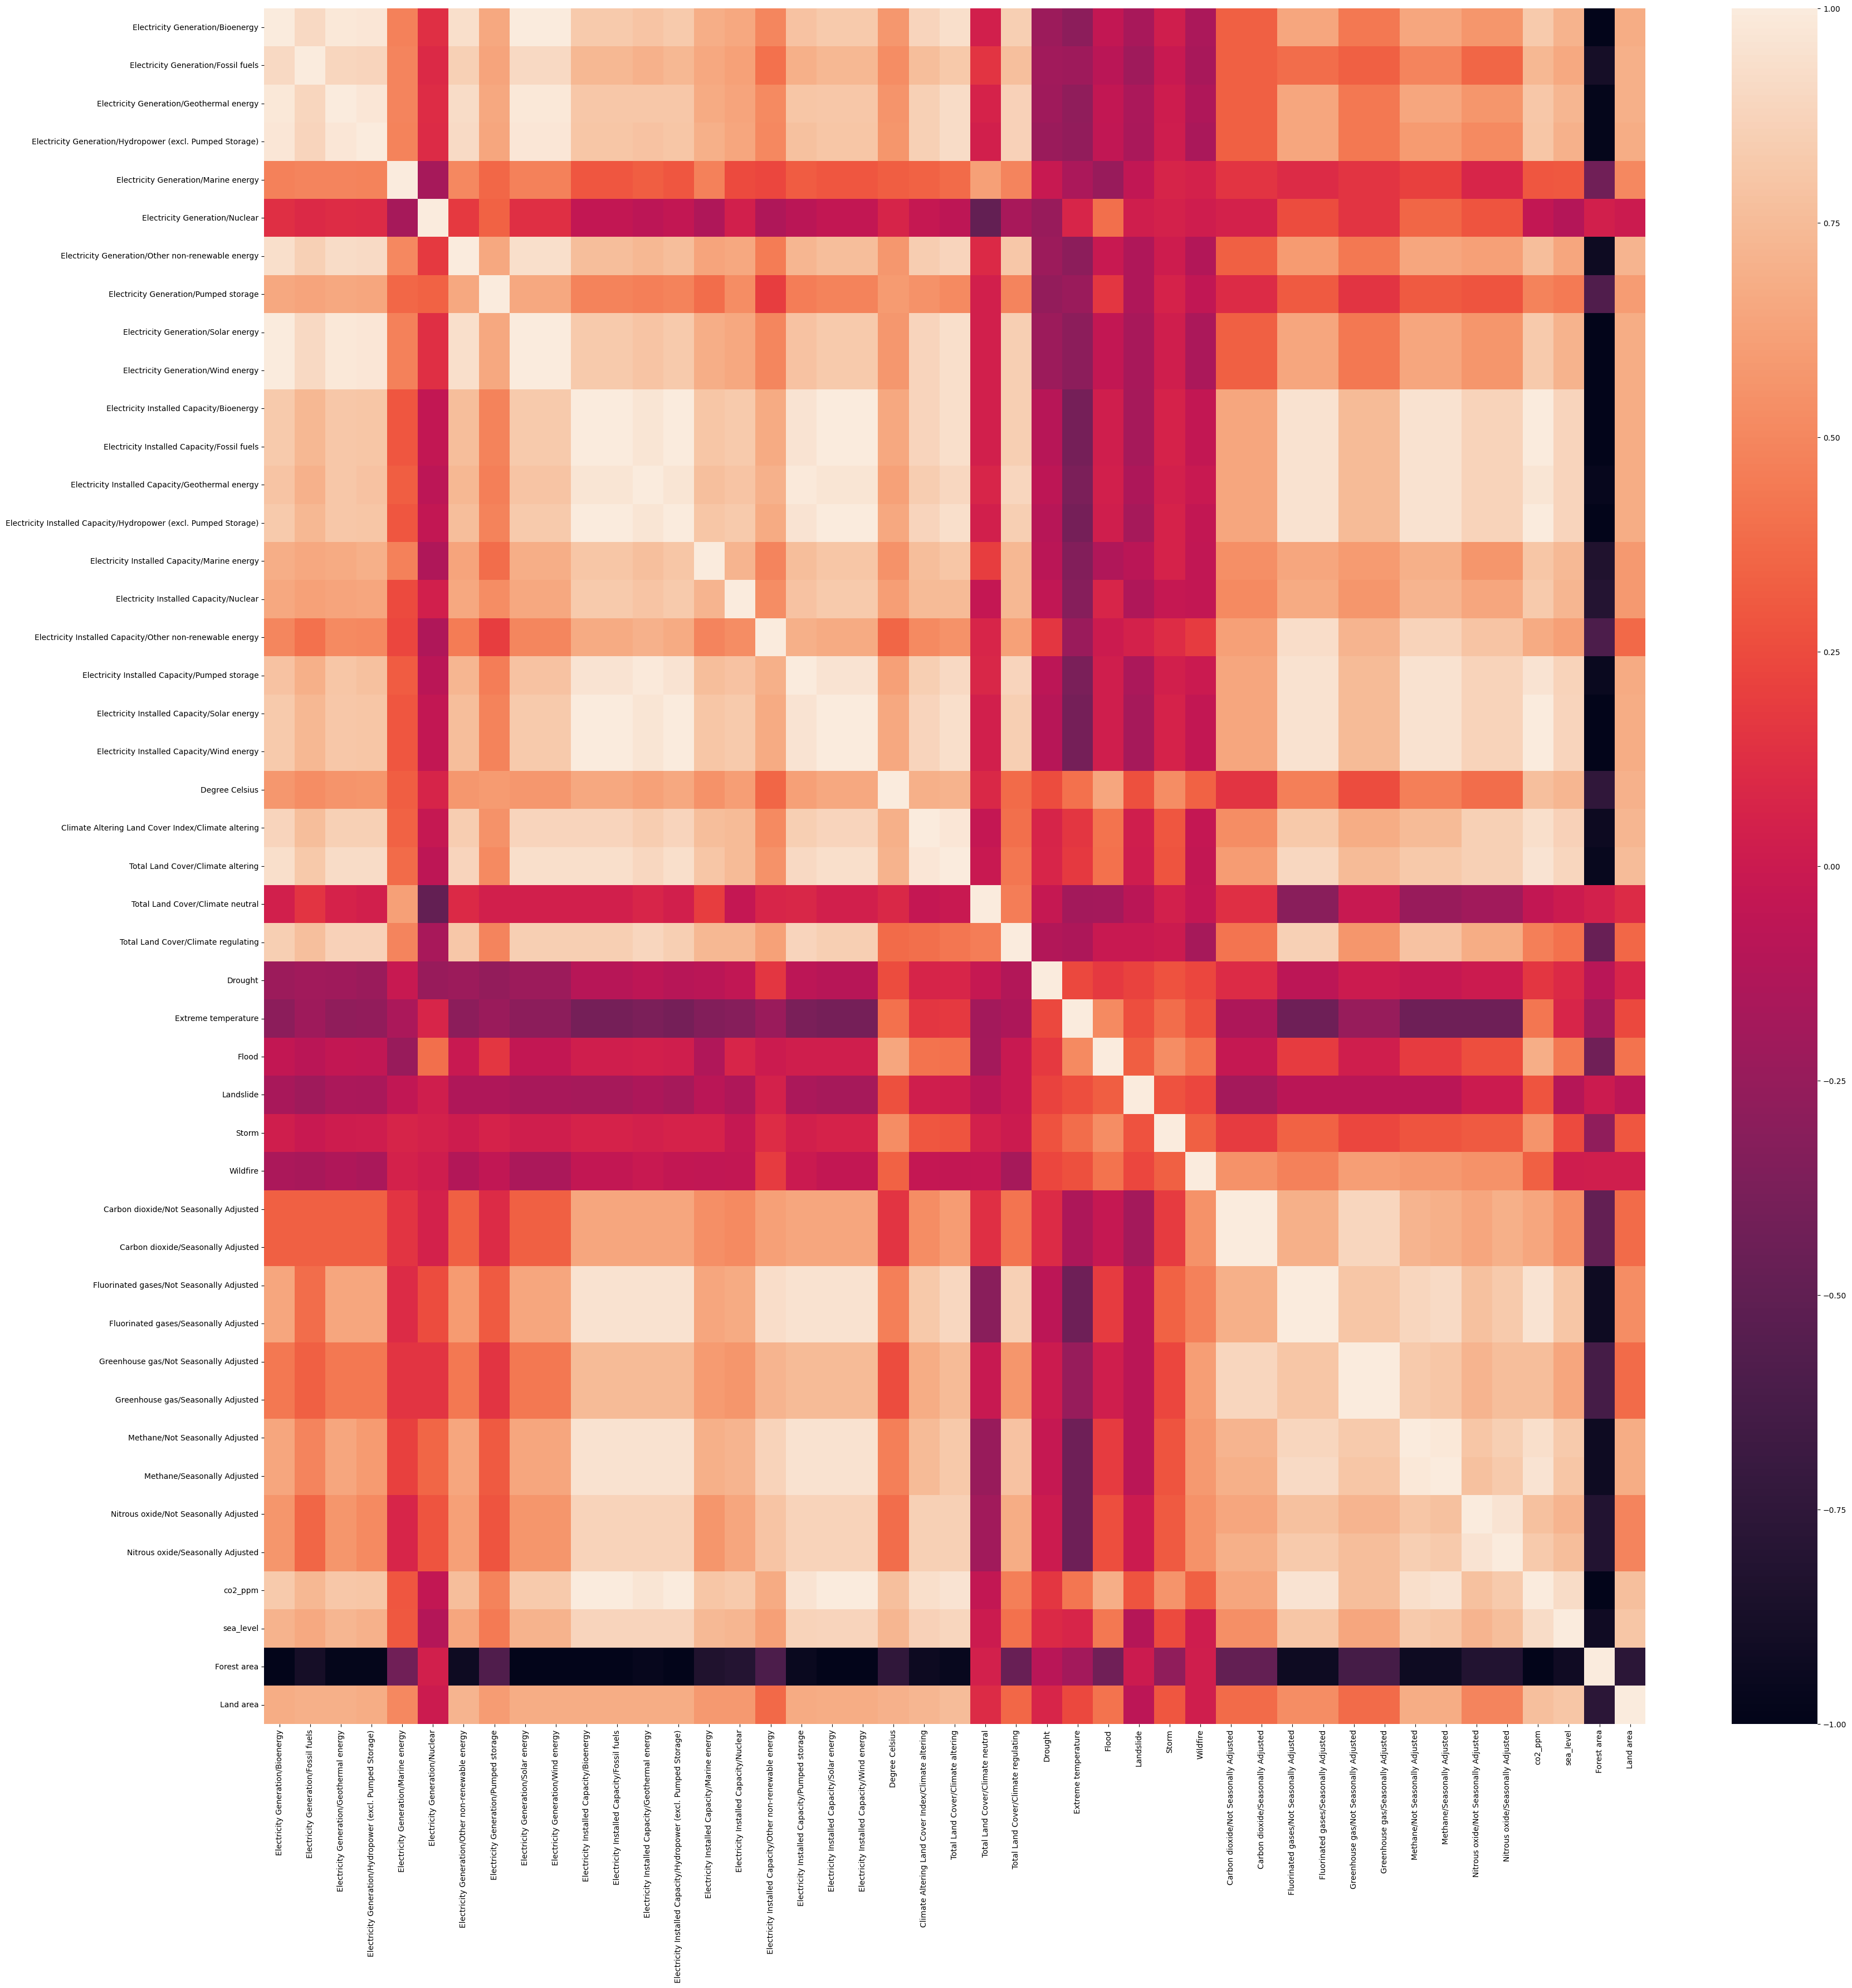

In [24]:
kendall_correlation_matrix = df.corr(method = 'kendall')
plt.figure(figsize=(40,40))
sbn.heatmap(kendall_correlation_matrix,annot = False)
plt.show()

In [25]:
df_clustering = df.ffill().bfill()
df_clustering

,Electricity Generation/Bioenergy,Electricity Generation/Fossil fuels,Electricity Generation/Geothermal energy,Electricity Generation/Hydropower (excl. Pumped Storage),Electricity Generation/Marine energy,Electricity Generation/Nuclear,Electricity Generation/Other non-renewable energy,Electricity Generation/Pumped storage,Electricity Generation/Solar energy,Electricity Generation/Wind energy,...,Greenhouse gas/Not Seasonally Adjusted,Greenhouse gas/Seasonally Adjusted,Methane/Not Seasonally Adjusted,Methane/Seasonally Adjusted,Nitrous oxide/Not Seasonally Adjusted,Nitrous oxide/Seasonally Adjusted,co2_ppm,sea_level,Forest area,Land area
timestep,,,,,,,,,,,,,,,,,,,,,
1958,142316.986,9.959860e+06,52571.035,2614844.000,545.889,2588111.258,64350.492,87491.913,1330.941,30925.915,...,23125.406880,23125.406880,4781.763673,4781.763673,1203.544903,1203.544903,315.232000,-22.306541,4.220757e+06,1.299094e+07
1959,142316.986,9.959860e+06,52571.035,2614844.000,545.889,2588111.258,64350.492,87491.913,1330.941,30925.915,...,23125.406880,23125.406880,4781.763673,4781.763673,1203.544903,1203.544903,315.980833,-22.306541,4.220757e+06,1.299094e+07
1960,142316.986,9.959860e+06,52571.035,2614844.000,545.889,2588111.258,64350.492,87491.913,1330.941,30925.915,...,23125.406880,23125.406880,4781.763673,4781.763673,1203.544903,1203.544903,316.910000,-22.306541,4.220757e+06,1.299094e+07
1961,142316.986,9.959860e+06,52571.035,2614844.000,545.889,2588111.258,64350.492,87491.913,1330.941,30925.915,...,23125.406880,23125.406880,4781.763673,4781.763673,1203.544903,1203.544903,317.644167,-22.306541,4.220757e+06,1.299094e+07
1962,142316.986,9.959860e+06,52571.035,2614844.000,545.889,2588111.258,64350.492,87491.913,1330.941,30925.915,...,23125.406880,23125.406880,4781.763673,4781.763673,1203.544903,1203.544903,318.454167,-22.306541,4.220757e+06,1.299094e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,572041.610,1.656223e+07,94645.217,4357351.497,983.975,2679742.086,150192.309,120370.133,842411.926,1588655.688,...,24523.723881,24523.723881,5116.883505,5116.883504,1291.998530,1291.998530,414.210833,80.437216,4.058927e+06,1.302624e+07
2021,614023.268,1.742686e+07,95251.031,4275354.865,970.024,2789348.256,165641.040,125304.326,1033925.733,1838662.870,...,25661.844919,25661.844920,5190.441027,5190.441027,1314.280290,1314.280290,416.413333,82.428703,4.058927e+06,1.302624e+07
2022,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,25972.791313,25972.791310,5299.940441,5299.940441,1319.103714,1319.103714,418.528333,88.991610,4.058927e+06,1.302624e+07


In [28]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 1, min_samples = 2).fit(df_clustering)
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, -1,  2,  2, -1,  3,  3,
        3,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

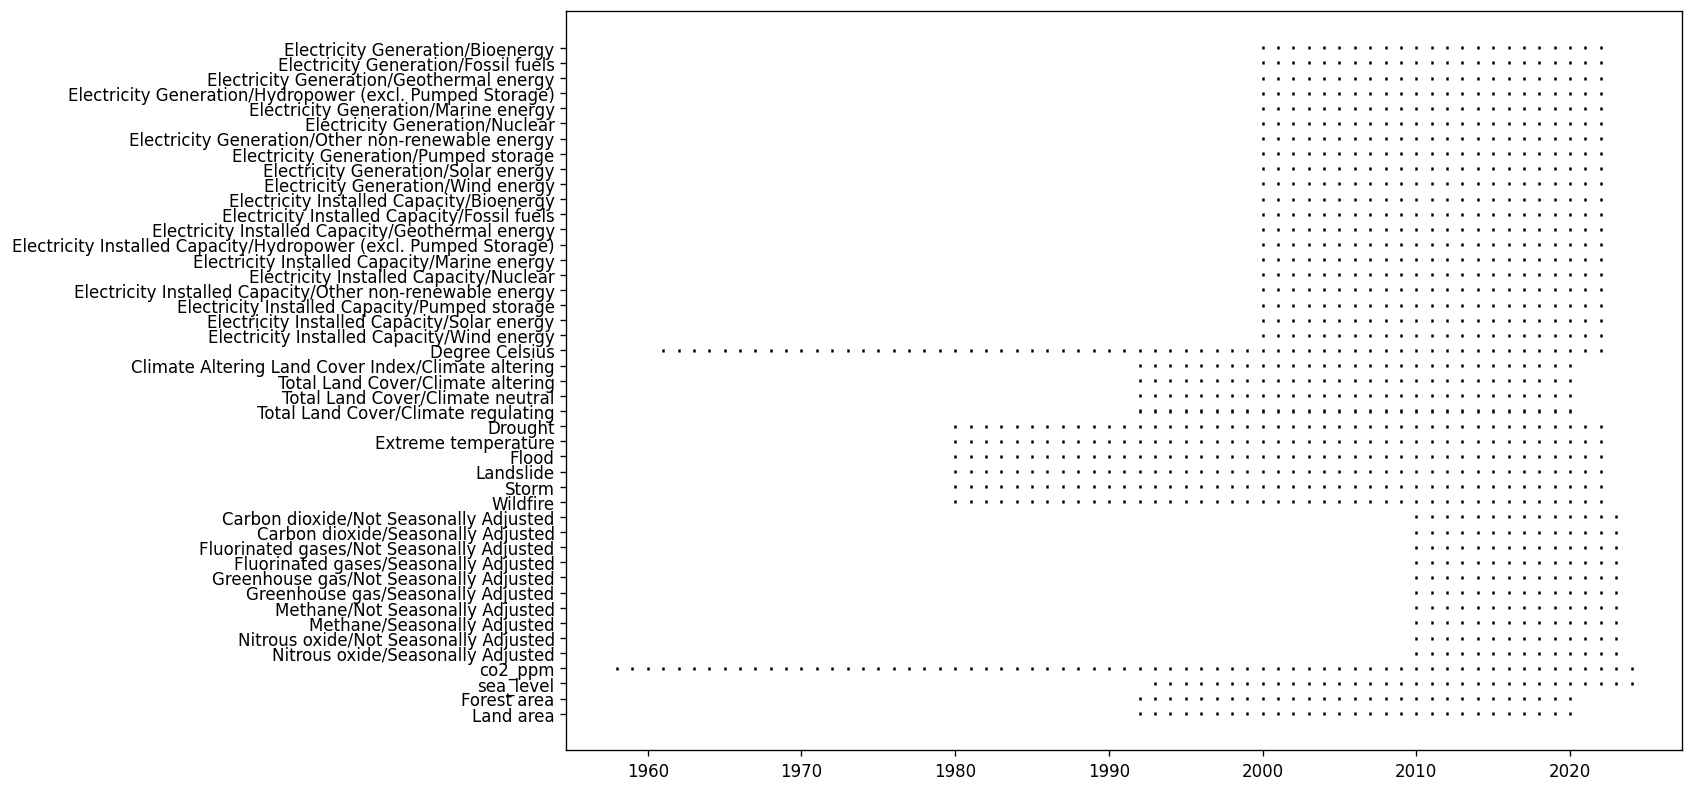

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=120)
for i, col in enumerate(df.columns):
  ax.eventplot(df.index[~df[col].isna()].astype(int).to_list(), lineoffsets=i, linelengths=0.2, color='black')
ax.invert_yaxis()
ax.set_yticks(list(range(len(df.columns))))
_ = ax.set_yticklabels(df.columns)

In [ ]:
def pearson(a, b, dt):
  c = a
  d = b
  if dt < 0:
    (c, d) = (b, a)
    dt *= -1
  c = c[dt:]
  if dt != 0:
    d = d[:-dt]
  mask = ~(np.isnan(c) | np.isnan(d))
  c = c[mask]
  d = d[mask]
  if len(c) < 5:
    return 0
  return pearsonr(c, d).statistic

In [ ]:
corrs = []
for col in df.columns:
  r = []
  for col2 in df.columns:
    t = []
    for dt in range(-10, 11):
      t.append(pearson(df[col].values, df[col2].values, dt))
    r.append(t)
  corrs.append(r)

In [ ]:
corrs = np.array(corrs)

In [ ]:
for i in range(len(df.columns)):
  if df.columns[i] == 'Degree Celsius':
    print(i)

20


Text(0.5, 1.0, 'Correlation of each feature to surface temperature across different lags')

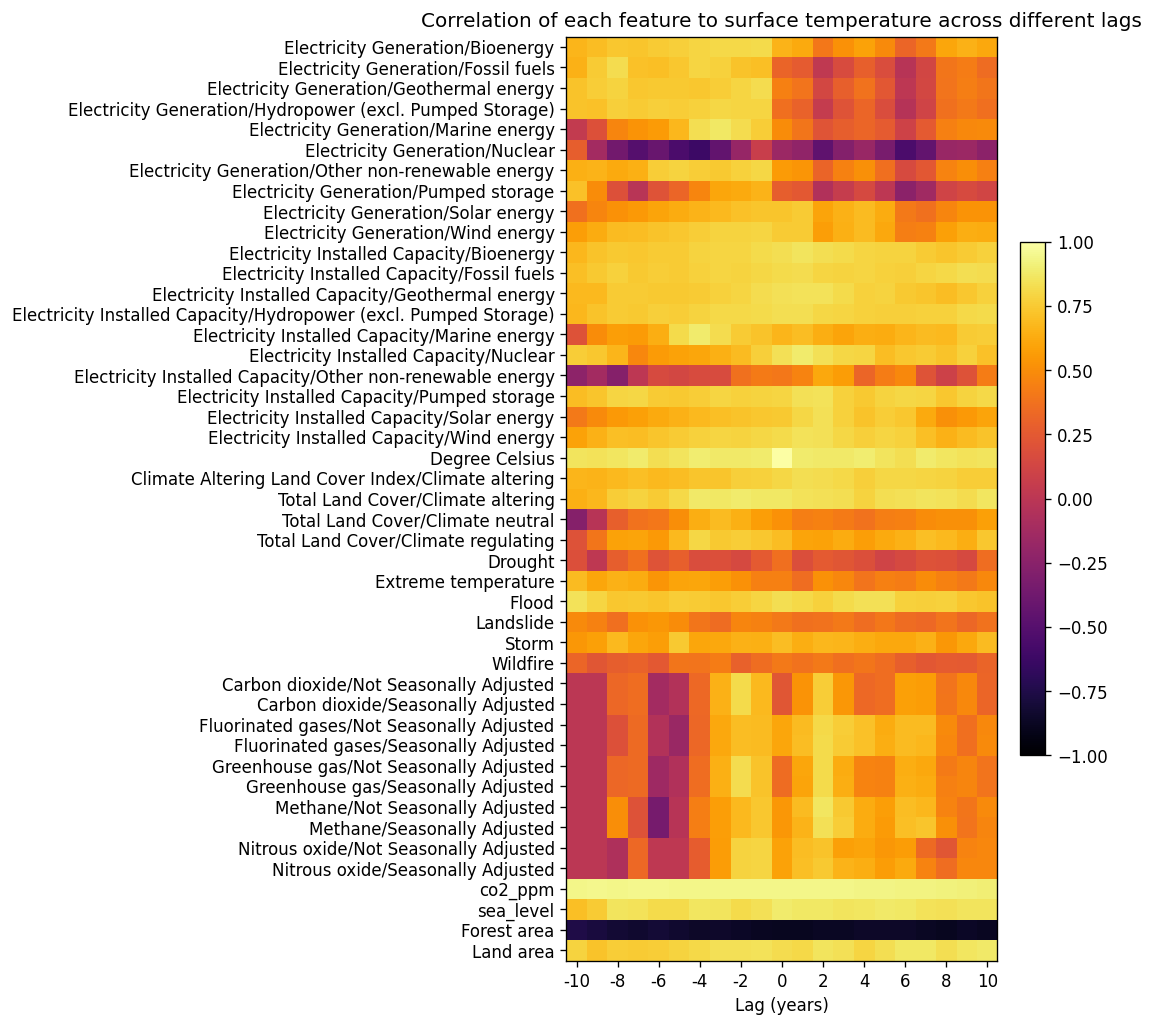

In [ ]:
plt.figure(figsize=(6, 10), dpi=120)
im = plt.imshow(corrs[:, 20, :], vmin=-1, vmax=1, cmap='inferno')
plt.yticks(range(0, 45), labels=df.columns)
plt.xticks(range(0, 21, 2), labels=range(-10, 11, 2))
plt.xlabel("Lag (years)")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("Correlation of each feature to surface temperature across different lags")

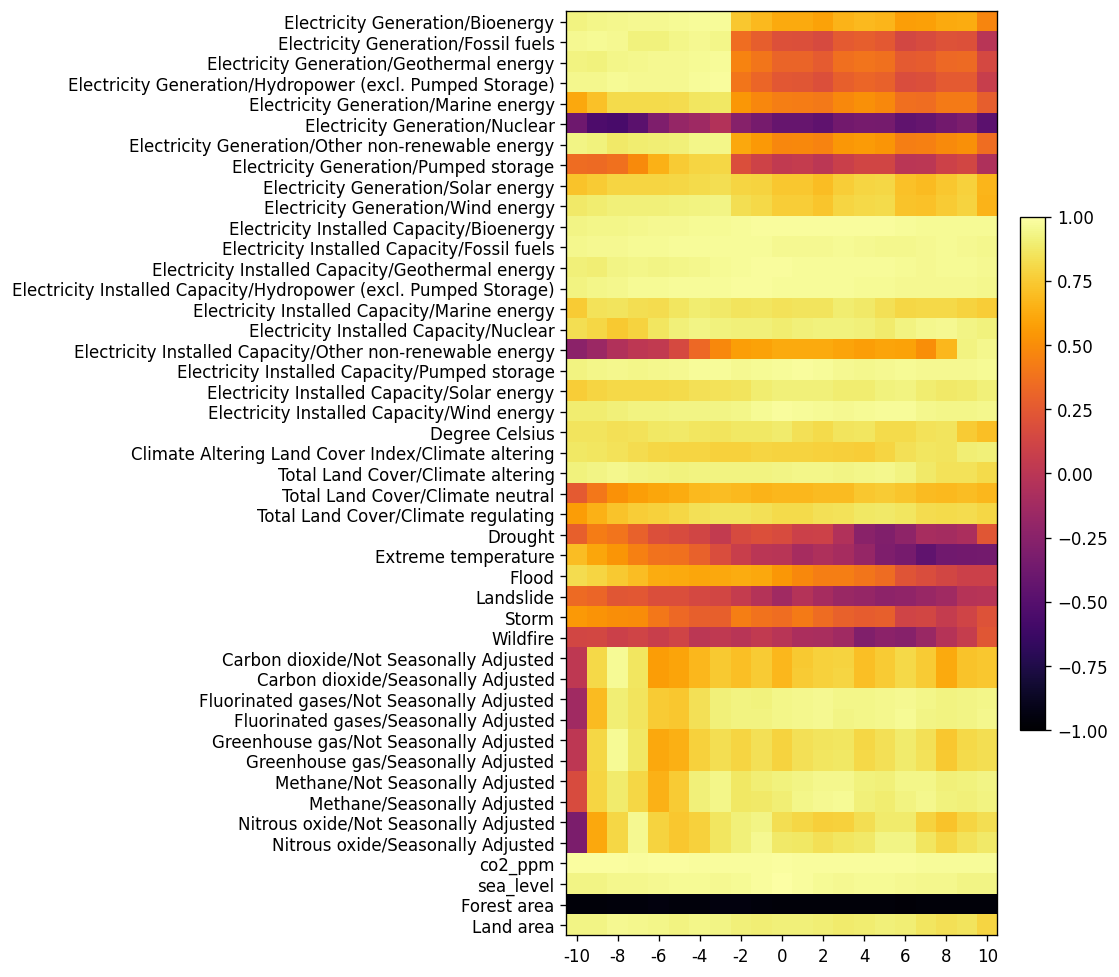

In [ ]:
plt.figure(figsize=(6, 10), dpi=120)
im = plt.imshow(corrs[:, -3, :], vmin=-1, vmax=1, cmap='inferno')
plt.yticks(range(0, 45), labels=df.columns)
plt.xticks(range(0, 21, 2), labels=range(-10, 11, 2))
plt.colorbar(im,fraction=0.046, pad=0.04)

In [ ]:
temp_truncated_data_1 = transposeDataFrame(truncated_data[1], 'Unit', 2).rename({"Unit": "temperature"})

In [ ]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state = 0, contamination = float(0.05))
temp_truncated_data_1['anomaly'] = model.fit_predict(temp_truncated_data_1[['Degree Celsius']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
temp_truncated_data_1['anomaly']

0     1
1     1
2     1
3    -1
4     1
     ..
57    1
58    1
59   -1
60    1
61    1
Name: anomaly, Length: 62, dtype: int64

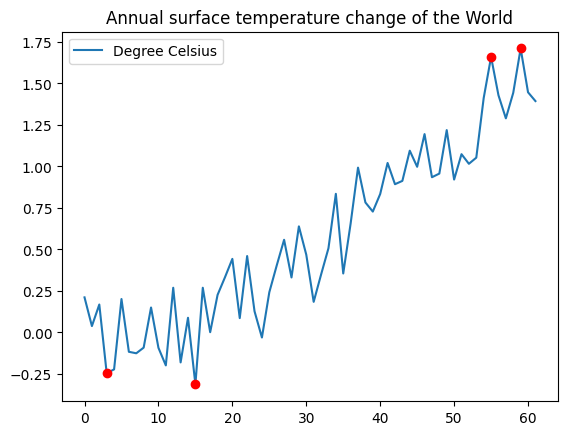

In [ ]:
temp_truncated_data_1[['Degree Celsius']].plot(kind="line")
outliers = temp_truncated_data_1.loc[temp_truncated_data_1['anomaly'] == -1]
outlier_index = list(outliers.index)
plt.plot(outliers['Degree Celsius'], 'o', color = 'red', label = 'outlier')
plt.title("Annual surface temperature change of the World")
plt.show()
# outliers

In [ ]:
temp_truncated_data_2 = temp_truncated_data_1.drop("anomaly",axis = 1)
temp_truncated_data_2

,timestep,Degree Celsius
0,1961,0.211
1,1962,0.038
2,1963,0.168
3,1964,-0.246
4,1965,-0.223
...,...,...
57,2018,1.290
58,2019,1.444
59,2020,1.711
60,2021,1.447


In [ ]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
data_tensor = tf.convert_to_tensor(temp_truncated_data_2.drop(
    'timestep', axis=1).values, dtype=tf.float32)

input_dim = temp_truncated_data_2.shape[1] - 1
encoding_dim = 10
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)

In [ ]:
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = temp_truncated_data_2.index

2/2 [==============================] - 0s 10ms/step


In [ ]:
anomaly_scores

0     0.044521
1     0.001444
2     0.028224
3     0.060516
4     0.049729
        ...   
57    1.664100
58    2.085136
59    2.927521
60    2.093809
61    1.943236
Name: anomaly_scores, Length: 62, dtype: float32

In [ ]:
temp_truncated_data_2

,timestep,Degree Celsius
0,1961,0.211
1,1962,0.038
2,1963,0.168
3,1964,-0.246
4,1965,-0.223
...,...,...
57,2018,1.290
58,2019,1.444
59,2020,1.711
60,2021,1.447


In [ ]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)

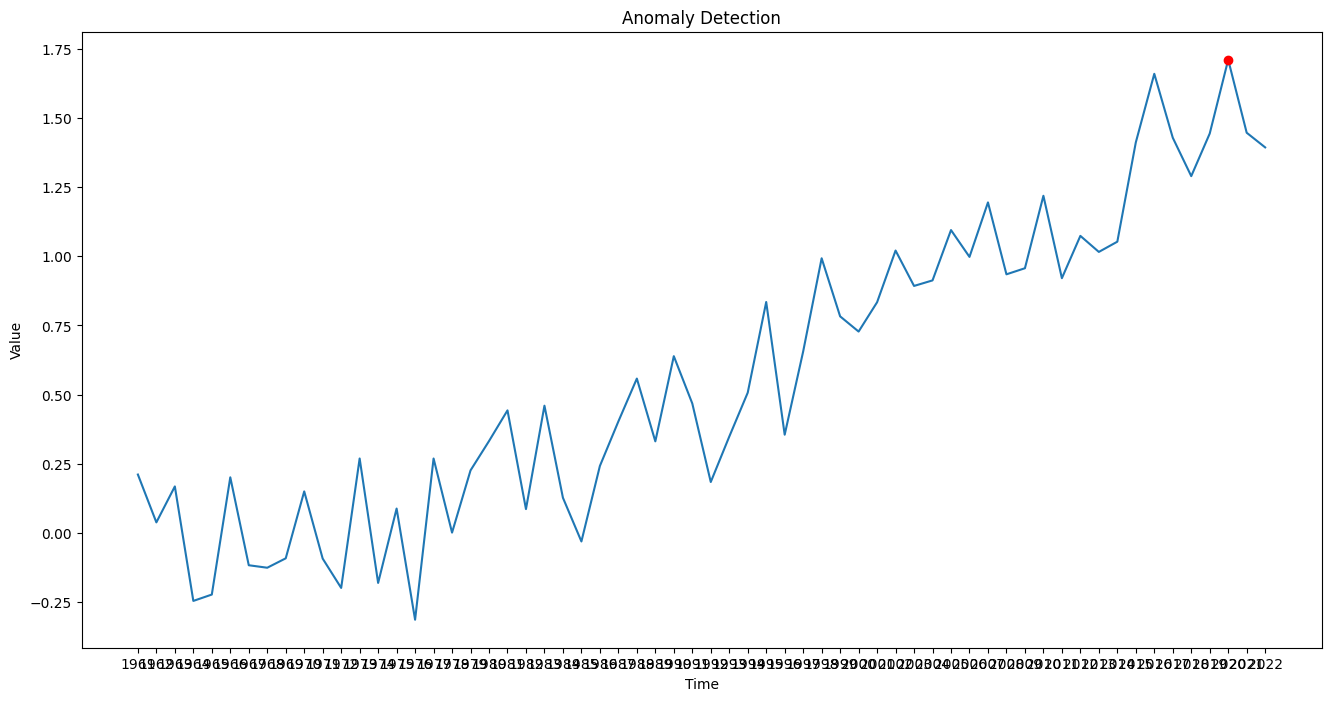

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(temp_truncated_data_2['timestep'],
         temp_truncated_data_2['Degree Celsius'])
plt.plot(temp_truncated_data_2['timestep'][anomalous],
         temp_truncated_data_2['Degree Celsius'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
import numpy as np

def traod(data, epsilon):
  """
  Detects outliers in trajectory data using the TRAOD (TRAjectory Outlier Detection) framework.

  Args:
      data: A numpy array (n_samples, n_features) representing the trajectory data.
              Each row represents a single trajectory.
      epsilon: A threshold for determining significant deviations in partitions.

  Returns:
      A numpy array (n_samples,) of boolean values indicating outliers.
  """

  outliers = np.zeros(data.shape[0], dtype=bool)  # Initialize outlier flags

  # Partition trajectories into segments
  partitions = []
  partitions_W = []
  for k, trajectory in enumerate(data):
    segments = []
    start_idx = 0
    for i in range(1, len(trajectory)):
      if np.linalg.norm(trajectory[i] - trajectory[start_idx]) > epsilon:
        segments.append(trajectory[start_idx:i])
        start_idx = i
    segments.append(trajectory[start_idx:])
    if k == 221:
      partitions_W.append(segments)
      # print(len(partitions))
    partitions.append(segments)

  # Compare partitions to detect outliers
  # for i, trajectory in enumerate(data):
  #   is_outlier = False
  #   for seg1 in partitions[i]:
  #     for j, other_traj in enumerate(data):
  #       if i != j:
  #         for seg2 in partitions[j]:
  #           if np.linalg.norm(seg1[0] - seg2[0]) <= epsilon and np.linalg.norm(seg1[-1] - seg2[-1]) <= epsilon:
  #             is_outlier = True
  #             break  # Break inner loop if a match is found
  #         if is_outlier:
  #           break  # Break outer loop if trajectory is an outlier

  #   outliers[i] = is_outlier
  for i, trajectory in enumerate(data):
      is_outlier = False
      for seg1 in partitions[i]:
        for seg2 in partitions_W[0]:
          if np.linalg.norm(seg1[0] - seg2[0]) <= epsilon and np.linalg.norm(seg1[-1] - seg2[-1]) <= epsilon:
                is_outlier = True
                break  # Break inner loop if a match is found
      outliers[i] = is_outlier

  return outliers

# # Example usage
# data = np.array([  # Sample trajectory data
#     [[1, 2], [2, 3], [3, 4], [3.5, 4.2]],
#     [[0, 0], [1, 1], [2, 2], [4, 5]],
#     [[5, 5], [6, 6], [7, 8], [10, 12]]  # Outlier trajectory
# ])
# epsilon = 0.5  # Threshold for significant deviations

# outliers = traod(data, epsilon)

# print("Outliers:", outliers)


In [ ]:
data[1]["Country"]

0      Afghanistan, Islamic Rep. of
1                           Albania
2                           Algeria
3                    American Samoa
4          Andorra, Principality of
                   ...             
220                  Western Sahara
221                           World
222                  Yemen, Rep. of
223                          Zambia
224                        Zimbabwe
Name: Country, Length: 225, dtype: object

In [ ]:
temp_truncated_data_3 = data[1].drop(["Indicator","Unit","Country"],axis = 1)
temp_truncated_data_3

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,-0.113,-0.164,0.847,-0.764,-0.244,0.226,-0.371,-0.423,-0.539,0.813,...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,0.627,0.326,0.075,-0.166,-0.388,0.559,-0.074,0.081,-0.013,-0.106,...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,0.164,0.114,0.077,0.250,-0.100,0.433,-0.026,-0.067,0.291,0.116,...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,0.079,-0.042,0.169,-0.140,-0.562,0.181,-0.368,-0.187,0.132,-0.047,...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,0.736,0.112,-0.752,0.308,-0.490,0.415,0.637,0.018,-0.137,0.121,...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.632,0.576,0.333,0.819,-0.337,0.284,-0.026,-0.368,0.383,0.543,...,1.423,1.401,1.510,1.732,2.204,0.942,1.477,2.069,1.593,1.970
221,0.211,0.038,0.168,-0.246,-0.223,0.201,-0.117,-0.126,-0.092,0.150,...,1.016,1.053,1.412,1.660,1.429,1.290,1.444,1.711,1.447,1.394
222,0.029,-0.009,0.169,-0.251,-0.623,0.089,-0.257,-0.252,0.262,0.387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,0.228,-0.168,-0.390,-0.279,-0.418,0.300,-0.014,-0.130,0.243,0.351,...,0.790,0.917,1.450,1.401,0.105,0.648,0.855,0.891,0.822,0.686


In [ ]:
# Example usage
# data = np.array([  # Sample trajectory data
#     [[1, 2], [2, 3], [3, 4], [3.5, 4.2]],
#     [[0, 0], [1, 1], [2, 2], [4, 5]],
#     [[5, 5], [6, 6], [7, 8], [10, 12]]  # Outlier trajectory
# ])
epsilon = 0.05  # Threshold for significant deviations

outliers = traod(temp_truncated_data_3.values, epsilon)

print("Outliers:", outliers)

Outliers: [ True  True  True  True  True  True  True  True  True False  True  True
  True False  True  True  True  True False False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True False  True  True  True  True  True  True  True
  True False False  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True False
  True False  True  True  True  True  True False False  True  True  True
 False  True  True False  True  True  True  True  True False False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False False  True
  True  True  True  True  True  True  Tru